In [1]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=542e2d11c84464b7b0292b00b7200588f8c36a2be0045ffa3f82b5e89bb5e0ba
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55640 sha256=a9493668fa9830bdf987e785396adcf48cbc7762cf198bf0c1d52aba57b0be31
  Stored in directory: /root/.cache/pip/wheels/12/f9/4d/ec5ad1c823c710fcc4473669fdcffc8891f4bc398c841af22e
Successfully built umap-learn pynndescent


In [2]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from pathlib import Path
import warnings
import os
import random
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm
import umap
from sklearn.preprocessing import StandardScaler

warnings.simplefilter('ignore')

In [3]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
fix_all_seeds(0)

In [4]:
SAVE_GRAPH = False
GRAPH_DIR = Path("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/EDA_20230219")

# データ読み込み

In [5]:
train_raw = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/train.pkl")
test_raw = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/test.pkl")

In [6]:
# センチネルの中央値部抽出
train = train_raw.iloc[:, 165:238]
train.columns

Index(['MED_AOT', 'MED_ARI', 'MED_ARVI', 'MED_AVI', 'MED_B02', 'MED_B03',
       'MED_B04', 'MED_B05', 'MED_B06', 'MED_B07', 'MED_B11', 'MED_B12',
       'MED_B8A', 'MED_BB1', 'MED_Bcc', 'MED_BGI', 'MED_BNDVI', 'MED_BOA',
       'MED_BRI', 'MED_BWDRVI', 'MED_CARI', 'MED_Chlred_edge', 'MED_CIgreen',
       'MED_CIrededge', 'MED_CLD', 'MED_CRred', 'MED_CSI', 'MED_CVI',
       'MED_D678_500', 'MED_Datt1', 'MED_Datt4', 'MED_DVI', 'MED_EVI',
       'MED_ExG', 'MED_GARI', 'MED_GDVI', 'MED_GI', 'MED_GLI', 'MED_GRNDVI',
       'MED_GVMI', 'MED_IF', 'MED_IO', 'MED_IPVI', 'MED_MCARI_MTVI2',
       'MED_MCARI_OSAVI', 'MED_MCARI2', 'MED_MGVI', 'MED_MIRBI', 'MED_mNDVI',
       'MED_MNSI', 'MED_MSBI', 'MED_MSI', 'MED_mSR', 'MED_MSR670', 'MED_MVI',
       'MED_MYVI', 'MED_NBR2', 'MED_NDBI', 'MED_NDFI2', 'MED_NDII', 'MED_NDRE',
       'MED_NDSI', 'MED_NDVI2', 'MED_NDVIre', 'MED_NDWI2', 'MED_PSSRc2',
       'MED_RDI', 'MED_Rededge1', 'MED_RGR', 'MED_SB550', 'MED_SR672_708',
       'MED_TCI', 'MED_WVP']

In [7]:
test = test_raw.loc[:, train.columns.to_list()]

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14140 entries, 0 to 14139
Data columns (total 73 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MED_AOT          13849 non-null  float32
 1   MED_ARI          13849 non-null  float32
 2   MED_ARVI         13849 non-null  float32
 3   MED_AVI          13849 non-null  float32
 4   MED_B02          13849 non-null  float32
 5   MED_B03          13849 non-null  float32
 6   MED_B04          13849 non-null  float32
 7   MED_B05          13849 non-null  float32
 8   MED_B06          13849 non-null  float32
 9   MED_B07          13849 non-null  float32
 10  MED_B11          13849 non-null  float32
 11  MED_B12          13849 non-null  float32
 12  MED_B8A          13849 non-null  float32
 13  MED_BB1          13849 non-null  float32
 14  MED_Bcc          13849 non-null  float32
 15  MED_BGI          13849 non-null  float32
 16  MED_BNDVI        13849 non-null  float32
 17  MED_BOA     

- 84と85は日付と時刻のデータ
- 86はただのID（情報なし）

# 分布の確認

In [9]:
def make_violinplot(colname):
    train_tmp = train[[colname]].dropna()
    train_tmp["label"] = "train"
    test_tmp = test[[colname]].dropna()
    test_tmp["label"] = "test"
    tmp = pd.concat((train_tmp, test_tmp))
    fig, ax = plt.subplots(figsize=(8, 12))
    ax.grid(color="gray", alpha=0.2)
    ax.set_title(colname)
    sns.violinplot(x="label", y=colname, data=tmp, ax=ax);

In [10]:
rm_cols = [
    "Date_Acquired",
    "Landsat_StartTime",
    "PRODUCT_ID",
    # "Landsat_num"
]
for col in train.columns:
    if col in rm_cols:
        continue
    make_violinplot(col)

Output hidden; open in https://colab.research.google.com to view.

# 相関の確認

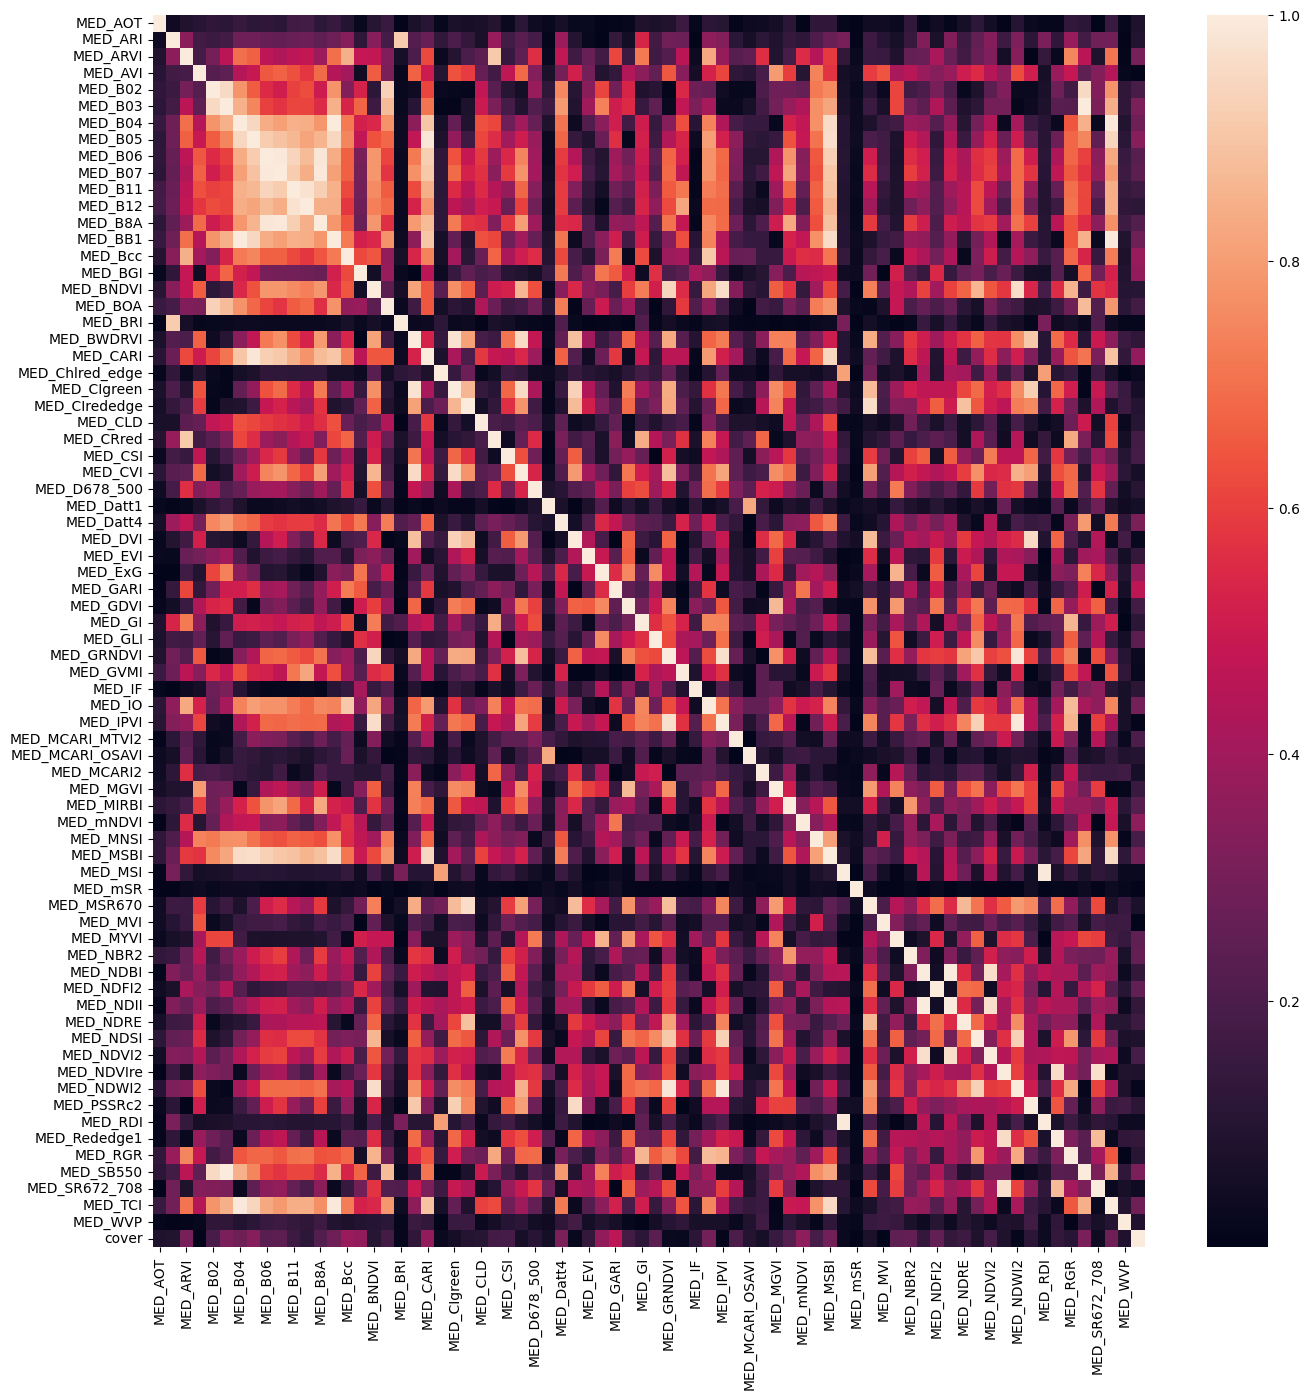

In [11]:
train["cover"] = train_raw["cover"]
use_cols = [col for col in train.columns if not col in rm_cols]
df_corr = train[use_cols].corr().abs()
fig = plt.figure(figsize=(16, 16))
sns.heatmap(df_corr);

# UMAPで次元削減

In [12]:
# 相関高い列は削除
corr = train[use_cols].corr()
threshold = 0.97
drop_numeric_cols=[]
pair=[]
for col in use_cols:
    for i in range(len(corr)):
        if abs(corr[col].iloc[i]) >= threshold and col != use_cols[i] :
            print(f"{col} and {use_cols[i]} are highly correlated...") 
            if col not in pair:
                pair.append(col)
                pair.append(use_cols[i])
                drop_numeric_cols.append(col) 
use_cols_new = list(set(use_cols)-set(drop_numeric_cols))
print(f"Dropping columns : {drop_numeric_cols}")
print("特徴量の数：", len(use_cols_new))

MED_B03 and MED_SB550 are highly correlated...
MED_B04 and MED_BB1 are highly correlated...
MED_B04 and MED_TCI are highly correlated...
MED_B05 and MED_CARI are highly correlated...
MED_B06 and MED_B07 are highly correlated...
MED_B06 and MED_B8A are highly correlated...
MED_B07 and MED_B06 are highly correlated...
MED_B07 and MED_B8A are highly correlated...
MED_B11 and MED_B12 are highly correlated...
MED_B12 and MED_B11 are highly correlated...
MED_B8A and MED_B06 are highly correlated...
MED_B8A and MED_B07 are highly correlated...
MED_BB1 and MED_B04 are highly correlated...
MED_BB1 and MED_TCI are highly correlated...
MED_BWDRVI and MED_CIgreen are highly correlated...
MED_CARI and MED_B05 are highly correlated...
MED_CIgreen and MED_BWDRVI are highly correlated...
MED_GRNDVI and MED_NDWI2 are highly correlated...
MED_IPVI and MED_NDWI2 are highly correlated...
MED_MSI and MED_RDI are highly correlated...
MED_NDBI and MED_NDII are highly correlated...
MED_NDII and MED_NDBI are h

In [13]:
def _clipping_train(df, col, low_lim=0.01):
    p01 = df[col].quantile(low_lim)
    p99 = df[col].quantile(1-low_lim)
    df[col] = np.clip(df[col], p01, p99)
    return p01, p99, df

def clip_features_train(df, cols_list):
    df_clipping = pd.DataFrame(columns=["low_lim", "high_lim"])
    for col in cols_list:
        p01, p99, df = _clipping_train(df, col)
        df_clipping.loc[col] = [p01, p99]
    return df, df_clipping

def clip_features_test(df, df_df_clipping):
    cols = df_df_clipping.index.values
    low_lims = df_df_clipping["low_lim"].values
    high_lims = df_df_clipping["high_lim"].values
    for i in range(len(cols)):
        df[cols[i]] = np.clip(df[cols[i]],
                                 low_lims[i],
                                 high_lims[i])
    return df

In [14]:
def plotly_scatterplot(df, x, y, hue, filename, title=""):
    cluster = sorted(df[hue].unique())
    n_cluster = len(cluster)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    fig = go.Figure()

    button = []
    tf = [True]*n_cluster
    tmp = dict(label="all",
               method="update",
               args=[{"visible": tf}]
               )
    button.append(tmp)

    for i,clu in enumerate(cluster):
        fig.add_trace(
            go.Scatter(
                x = df[df[hue]==clu][x],
                y = df[df[hue]==clu][y],
                opacity=0.5,
                mode="markers",
                name=str(clu),
                marker=dict(color=colors[i])
                )
            )
        tf = [False]*n_cluster
        tf[i] = True
        tmp = dict(label=clu,
                   method="update",
                   args=[{"visible": tf}]
                   )
        button.append(tmp)


    fig.update_layout(
        updatemenus=[
            dict(type="buttons",
                 x=1.15,
                 y=1,
                 buttons=button
                 )
            ])

    x_min = df[x].min()
    x_max = df[x].max()
    x_range = x_max - x_min
    y_min = df[y].min()
    y_max = df[y].max()
    y_range = y_max - y_min

    fig.update_xaxes(range=[x_min-x_range/10, x_max+x_range/10])
    fig.update_yaxes(range=[y_min-y_range/10, y_max+x_range/10])
    fig.update_layout(
    title_text=title,
    height=800,
    width=800,
    xaxis_title=x,
    yaxis_title=y,
    showlegend=False,
    )

    if SAVE_GRAPH:
        fig.write_html(GRAPH_DIR / f"{filename}.html")
    fig.show()

In [15]:
df_umap_raw = train[use_cols_new]
df_umap_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14140 entries, 0 to 14139
Data columns (total 61 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MED_ARI          13849 non-null  float32
 1   MED_CIgreen      13849 non-null  float32
 2   MED_NDFI2        13849 non-null  float32
 3   MED_MSR670       13849 non-null  float32
 4   MED_MVI          13849 non-null  float32
 5   MED_SB550        13849 non-null  float32
 6   MED_GI           13849 non-null  float32
 7   MED_GDVI         13849 non-null  float32
 8   MED_Datt4        13849 non-null  float32
 9   MED_DVI          13849 non-null  float32
 10  MED_CVI          13849 non-null  float32
 11  MED_NDRE         13849 non-null  float32
 12  MED_GARI         13849 non-null  float32
 13  MED_EVI          13849 non-null  float32
 14  MED_CLD          13849 non-null  float32
 15  MED_PSSRc2       13849 non-null  float32
 16  MED_ExG          13849 non-null  float32
 17  MED_MNSI    

In [16]:
df_umap_raw = df_umap_raw.dropna().reset_index(drop=True)
# cover抜く
df_umap = df_umap_raw.drop("cover", axis=1)
df_umap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13849 entries, 0 to 13848
Data columns (total 60 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MED_ARI          13849 non-null  float32
 1   MED_CIgreen      13849 non-null  float32
 2   MED_NDFI2        13849 non-null  float32
 3   MED_MSR670       13849 non-null  float32
 4   MED_MVI          13849 non-null  float32
 5   MED_SB550        13849 non-null  float32
 6   MED_GI           13849 non-null  float32
 7   MED_GDVI         13849 non-null  float32
 8   MED_Datt4        13849 non-null  float32
 9   MED_DVI          13849 non-null  float32
 10  MED_CVI          13849 non-null  float32
 11  MED_NDRE         13849 non-null  float32
 12  MED_GARI         13849 non-null  float32
 13  MED_EVI          13849 non-null  float32
 14  MED_CLD          13849 non-null  float32
 15  MED_PSSRc2       13849 non-null  float32
 16  MED_ExG          13849 non-null  float32
 17  MED_MNSI    

In [17]:
# Clipping
# cover抜く
use_cols_new.remove("cover")
df_umap, df_clip = clip_features_train(df_umap, use_cols_new)

In [18]:
# 標準化を行う
scaler = StandardScaler()
X = scaler.fit_transform(df_umap.values)

In [19]:
# https://www.kaggle.com/code/mrisdal/dimensionality-reduction-with-umap-on-mnist/notebook
model = umap.UMAP(
    n_neighbors=200,
    n_components=2,
    min_dist=0.02,
    random_state=42
    # metric='euclidean',
)

embedding = model.fit_transform(X)

df_embedded = pd.DataFrame(
    embedding,
    columns=["dim0", "dim1"]
)
df_embedded

,dim0,dim1
0,4.039891,-3.133781
1,-0.747976,15.976029
2,0.661086,4.496330
3,0.902908,-1.158295
4,1.340913,-5.066039
...,...,...
13844,3.511483,2.984781
13845,-1.186629,-0.624840
13846,3.153039,-3.221176
13847,0.525745,-7.789593


In [20]:
# テストデータ
df_umap_test = test[use_cols_new]
df_umap_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4039 entries, 0 to 4038
Data columns (total 60 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MED_ARI          4017 non-null   float64
 1   MED_CIgreen      4017 non-null   float64
 2   MED_NDFI2        4017 non-null   float64
 3   MED_MSR670       4017 non-null   float64
 4   MED_MVI          4017 non-null   float64
 5   MED_SB550        4017 non-null   float64
 6   MED_GI           4017 non-null   float64
 7   MED_GDVI         4017 non-null   float64
 8   MED_Datt4        4017 non-null   float64
 9   MED_DVI          4017 non-null   float64
 10  MED_CVI          4017 non-null   float64
 11  MED_NDRE         4017 non-null   float64
 12  MED_GARI         4017 non-null   float64
 13  MED_EVI          4017 non-null   float64
 14  MED_CLD          4017 non-null   float64
 15  MED_PSSRc2       4017 non-null   float64
 16  MED_ExG          4017 non-null   float64
 17  MED_MNSI      

In [21]:
df_umap_test.dropna(inplace=True)
df_umap_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4017 entries, 0 to 4038
Data columns (total 60 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MED_ARI          4017 non-null   float64
 1   MED_CIgreen      4017 non-null   float64
 2   MED_NDFI2        4017 non-null   float64
 3   MED_MSR670       4017 non-null   float64
 4   MED_MVI          4017 non-null   float64
 5   MED_SB550        4017 non-null   float64
 6   MED_GI           4017 non-null   float64
 7   MED_GDVI         4017 non-null   float64
 8   MED_Datt4        4017 non-null   float64
 9   MED_DVI          4017 non-null   float64
 10  MED_CVI          4017 non-null   float64
 11  MED_NDRE         4017 non-null   float64
 12  MED_GARI         4017 non-null   float64
 13  MED_EVI          4017 non-null   float64
 14  MED_CLD          4017 non-null   float64
 15  MED_PSSRc2       4017 non-null   float64
 16  MED_ExG          4017 non-null   float64
 17  MED_MNSI      

In [22]:
# Clipping
df_umap_test = clip_features_test(df_umap_test, df_clip)

In [23]:
# 標準化を行う
X_test = scaler.transform(df_umap_test.values)

embedding_test = model.transform(X_test)

df_embedded_test = pd.DataFrame(
    embedding_test,
    columns=["dim0", "dim1"]
)
df_embedded_test.head()

,dim0,dim1
0,-3.684915,1.364356
1,2.565723,1.258662
2,1.877466,4.965201
3,1.581059,3.805587
4,-3.491848,-1.050713


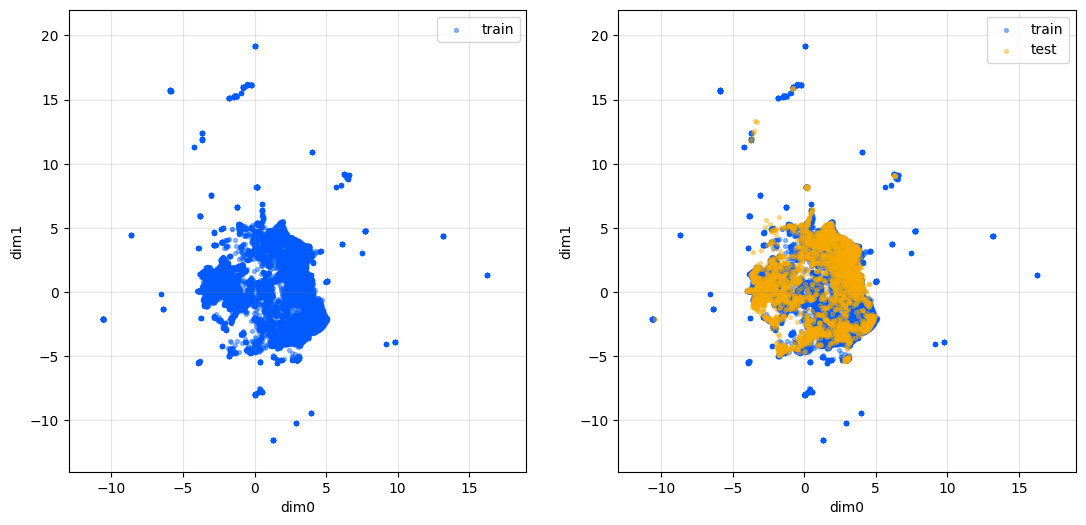

In [24]:
xlim = [
    np.floor(min(df_embedded["dim0"].min(), df_embedded_test["dim0"].min())) - 2,
    np.ceil(max(df_embedded["dim0"].max(), df_embedded_test["dim0"].max())) + 2,
]
ylim = [
    np.floor(min(df_embedded["dim1"].min(), df_embedded_test["dim1"].min())) - 2,
    np.ceil(max(df_embedded["dim1"].max(), df_embedded_test["dim1"].max())) + 2,
]

fig = plt.figure(figsize=(13, 6))
ax1 = fig.add_subplot(121)
ax1.grid(alpha=0.2, color="gray")
ax1.scatter(
    df_embedded["dim0"],
    df_embedded["dim1"],
    s=8,
    alpha=0.4,
    color="#005aff",
    label="train"
)
ax1.set_xlabel("dim0")
ax1.set_ylabel("dim1")
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.grid(alpha=0.2, color="gray")
ax2.scatter(
    df_embedded["dim0"],
    df_embedded["dim1"],
    s=8,
    alpha=0.4,
    color="#005aff",
    label="train"
)
ax2.scatter(
    df_embedded_test["dim0"],
    df_embedded_test["dim1"],
    s=8,
    alpha=0.4,
    color="#f6aa00",
    label="test"
)
ax2.set_xlabel("dim0")
ax2.set_ylabel("dim1")
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.legend()

plt.show()

In [25]:
df_embedded["cover_mod"] = "0 (cover=0)"
df_embedded.loc[df_umap_raw["cover"]>0, "cover_mod"] = "1 (0<cover<0.2)"
df_embedded.loc[df_umap_raw["cover"]>=0.2, "cover_mod"] = "2 (0.2<=cover<0.4)"
df_embedded.loc[df_umap_raw["cover"]>=0.4, "cover_mod"] = "3 (0.4<=cover<0.6)"
df_embedded.loc[df_umap_raw["cover"]>=0.6, "cover_mod"] = "4 (0.6<=cover<0.8)"
df_embedded.loc[df_umap_raw["cover"]>=0.8, "cover_mod"] = "5 (0.8<=cover<1)"
df_embedded.loc[df_umap_raw["cover"]>=1, "cover_mod"] = "6 (cover=1)"
df_embedded.head()

,dim0,dim1,cover_mod
0,4.039891,-3.133781,1 (0<cover<0.2)
1,-0.747976,15.976029,4 (0.6<=cover<0.8)
2,0.661086,4.496330,1 (0<cover<0.2)
3,0.902908,-1.158295,3 (0.4<=cover<0.6)
4,1.340913,-5.066039,2 (0.2<=cover<0.4)


In [26]:
df_embedded.shape

(13849, 3)

In [27]:
plotly_scatterplot(df_embedded, "dim0", "dim1", "cover_mod", filename="20230412_LandsatのUMAP", title="LandsatのUMAP")